# Tarea 4 - Modelamiento
Roles involucrados: Ciencia de datos
Encargada: Ana Sofía Arizmendi - 202115093


### Instalar librerias

In [1]:
%pip install -q tensorflow scikeras scikit-learn pandas numpy joblib
%pip install torch scikit-learn matplotlib -q  
%pip install -q "scikit-learn<1.4"
import os, json, joblib, numpy as np, pandas as pd
from pathlib import Path
import os, json, joblib, numpy as np, pandas as pd
from pathlib import Path


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikeras 0.13.0 requires scikit-learn>=1.4.2, but you have scikit-learn 1.3.2 which is incompatible.

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Cargar datos

In [2]:
import tensorflow as tf
# Ruta local al CSV limpio (Tarea 3)
CSV_PATH = Path("/Users/anasofiaarizmendi/Desktop/U/20252/Analitica/Proyecto 1/Repo_Proyecto_1/Tarea_3/incident_event_log_clean.csv")
df = pd.read_csv(CSV_PATH)
print(df.columns)

2025-09-14 21:11:46.059331: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Index(['number', 'incident_state', 'active', 'reassignment_count',
       'reopen_count', 'sys_mod_count', 'made_sla', 'caller_id', 'opened_by',
       'opened_at', 'sys_updated_by', 'sys_updated_at', 'contact_type',
       'location', 'category', 'subcategory', 'impact', 'urgency', 'knowledge',
       'u_priority_confirmation', 'notify', 'closed_code', 'resolved_by',
       'resolved_at', 'closed_at', 'resolution_time', 'closure_time',
       'is_outlier_reassignment', 'is_outlier_reopen', 'is_invalid_time',
       'is_outlier_resolution_time', 'is_outlier_closure_time',
       'resolution_time_log'],
      dtype='object')


### Definir Variables X

In [3]:
import numpy as np
import pandas as pd

# Categóricas válidas
CAT_T0 = ["impact","urgency","contact_type","category","subcategory","location"]

# Columnas a excluir (leakage/IDs/targets)
EXCLUDE = [
    "number","caller_id","opened_by",
    "resolved_at","closed_at",
    "resolution_time","closure_time","resolution_time_log",
    "resolved_by","closed_code","close_code",
    "knowledge","made_sla",
    "sys_updated_at","sys_updated_by",
    "is_outlier_reassignment","is_outlier_reopen","is_invalid_time",
    "is_outlier_resolution_time","is_outlier_closure_time",
    "incident_state",
    "reassignment_count","reopen_count","sys_mod_count",
]

def add_minimal_time_features(df: pd.DataFrame,
                              time_col: str = "opened_at",
                              tz: str | None = "America/Bogota") -> pd.DataFrame:
    """
    Deriva SOLO las variables de tiempo acordadas:
      - opened_month (1–12)
      - opened_time_decimal (hora con minutos, en horas decimales 0..24)
      - opened_is_weekend (0/1)
      - opened_dow_name (Lunes..Domingo)
    """
    out = df.copy()
    if time_col not in out.columns:
        raise KeyError(f"No existe la columna '{time_col}' en el DataFrame.")

    # Parseo robusto a datetime (asumimos UTC, convertimos a zona local si se indica)
    dt = pd.to_datetime(out[time_col], errors="coerce", utc=True)
    if tz is not None:
        dt = dt.dt.tz_convert(tz)
    dt = dt.dt.tz_localize(None)

    # Mes 1-12
    out["opened_month"] = dt.dt.month

    # Hora con minutos como horas decimales (ej. 13:30 -> 13.5)
    out["opened_time_decimal"] = dt.dt.hour + dt.dt.minute / 60.0

    # Fin de semana (sábado/domingo)
    dow = dt.dt.dayofweek  # 0=lun ... 6=dom
    out["opened_is_weekend"] = (dow >= 5).astype(int)

    # Día en texto (Lunes..Domingo) — categórica limpia para OHE
    dias = np.array(["Lunes","Martes","Miércoles","Jueves","Viernes","Sábado","Domingo"])
    out["opened_dow_name"] = dias[dow.fillna(0).astype(int).values]
    out["opened_dow_name"] = out["opened_dow_name"].astype("category")

    return out

def build_X_minimal(df: pd.DataFrame,
                    time_col: str = "opened_at",
                    tz: str | None = "America/Bogota") -> pd.DataFrame:
    """
    Devuelve X con 4 features de tiempo acordadas y excluye leakage/IDs/targets
    """
    d = add_minimal_time_features(df, time_col=time_col, tz=tz)

    # Excluir columnas prohibidas
    drop_cols = [c for c in EXCLUDE if c in d.columns]
    d = d.drop(columns=drop_cols, errors="ignore")

    # Selección final de columnas
    time_cols = ["opened_month","opened_time_decimal","opened_is_weekend","opened_dow_name"]
    time_present = [c for c in time_cols if c in d.columns]
    cat_present  = [c for c in CAT_T0 if c in d.columns]
    cols_final   = time_present + cat_present

    # Quitar la columna original de tiempo si estuviera en el set
    if time_col in cols_final:
        cols_final.remove(time_col)

    # Armar X y tipificar: numéricas a float; categóricas como category
    X = d[cols_final].copy()
    for c in ["opened_month","opened_time_decimal","opened_is_weekend"]:
        if c in X.columns:
            X[c] = pd.to_numeric(X[c], errors="coerce")

    # Asegurar dtype categórico para las categóricas t0
    for c in cat_present + (["opened_dow_name"] if "opened_dow_name" in X.columns else []):
        if c in X.columns:
            X[c] = X[c].astype("category")

    # Info de control
    print(f"[OK] X listo → shape={X.shape}")
    print(" - Tiempo:", [c for c in time_cols if c in X.columns])
    print(" - Categóricas t0:", cat_present)
    if drop_cols:
        print(" - Excluidas (leakage/IDs):", drop_cols)

    return X

# ====== EJECUCIÓN ======
X = build_X_minimal(df, time_col="opened_at", tz="America/Bogota")

print("\nVista de X (primeras 5 filas):")
display(X.head(5))

print("\nTipos de columnas:")
display(X.dtypes.to_frame("dtype").T)

print("\nResumen de nulos por columna:")
display(X.isna().sum().sort_values(ascending=False).to_frame("nulos").T)


[OK] X listo → shape=(118945, 10)
 - Tiempo: ['opened_month', 'opened_time_decimal', 'opened_is_weekend', 'opened_dow_name']
 - Categóricas t0: ['impact', 'urgency', 'contact_type', 'category', 'subcategory', 'location']
 - Excluidas (leakage/IDs): ['number', 'caller_id', 'opened_by', 'resolved_at', 'closed_at', 'resolution_time', 'closure_time', 'resolution_time_log', 'resolved_by', 'closed_code', 'knowledge', 'made_sla', 'sys_updated_at', 'sys_updated_by', 'is_outlier_reassignment', 'is_outlier_reopen', 'is_invalid_time', 'is_outlier_resolution_time', 'is_outlier_closure_time', 'incident_state', 'reassignment_count', 'reopen_count', 'sys_mod_count']

Vista de X (primeras 5 filas):


,opened_month,opened_time_decimal,opened_is_weekend,opened_dow_name,impact,urgency,contact_type,category,subcategory,location
0,2,20.266667,1,Domingo,Medium,Medium,Phone,Category 55,Subcategory 170,Location 143
1,2,20.266667,1,Domingo,Medium,Medium,Phone,Category 55,Subcategory 170,Location 143
2,2,20.266667,1,Domingo,Medium,Medium,Phone,Category 55,Subcategory 170,Location 143
3,2,20.266667,1,Domingo,Medium,Medium,Phone,Category 55,Subcategory 170,Location 143
4,2,23.666667,1,Domingo,Medium,Medium,Phone,Category 40,Subcategory 215,Location 165



Tipos de columnas:


,opened_month,opened_time_decimal,opened_is_weekend,opened_dow_name,impact,urgency,contact_type,category,subcategory,location
dtype,int32,float64,int64,category,category,category,category,category,category,category



Resumen de nulos por columna:


,subcategory,location,category,opened_month,opened_time_decimal,opened_is_weekend,urgency,impact,opened_dow_name,contact_type
nulos,82,70,52,0,0,0,0,0,0,0


### Entrenamiento, Modelo e Implementación
Se realizan dos modelos

Device: cpu
Cutoff temporal: 2016-05-08 19:01:00
Train: (95161, 10)  Test: (23784, 10)
Dimensión de entrada tras OHE+escala: 467
Epoch  10/60  train MSE=155.5507
Epoch  20/60  train MSE=137.5912
Epoch  30/60  train MSE=123.4674
Epoch  40/60  train MSE=113.3539
Epoch  50/60  train MSE=108.2386
Epoch  60/60  train MSE=104.3381


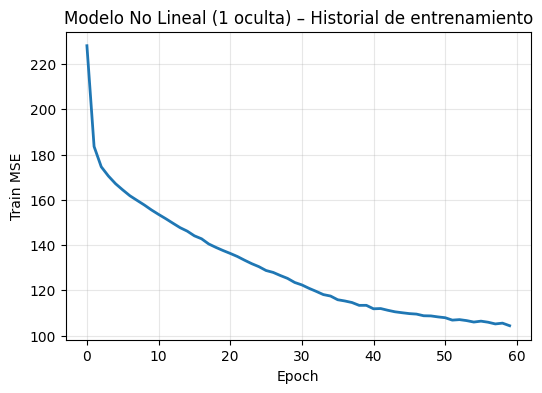

[No lineal (1 oculta)] Test  MSE=264.0430  MAE=9.5588  R2=-0.3133


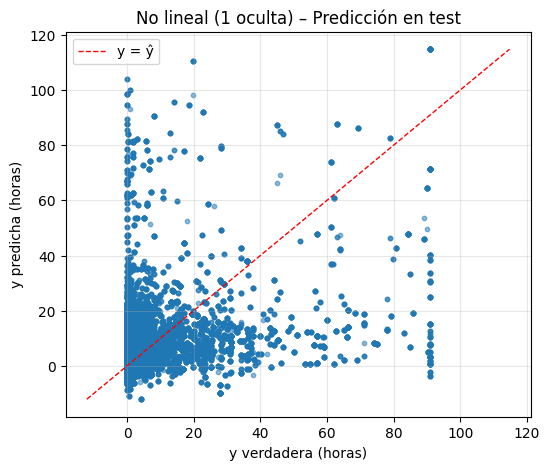

Epoch  13/80  train MSE=70.5723
Epoch  26/80  train MSE=54.0925
Epoch  39/80  train MSE=47.0724
Epoch  52/80  train MSE=43.6257
Epoch  65/80  train MSE=40.3048
Epoch  78/80  train MSE=38.2439


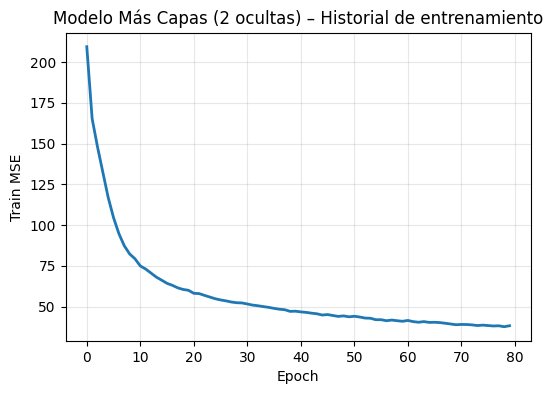

[Más capas (2 ocultas)] Test  MSE=280.6667  MAE=8.7202  R2=-0.3959


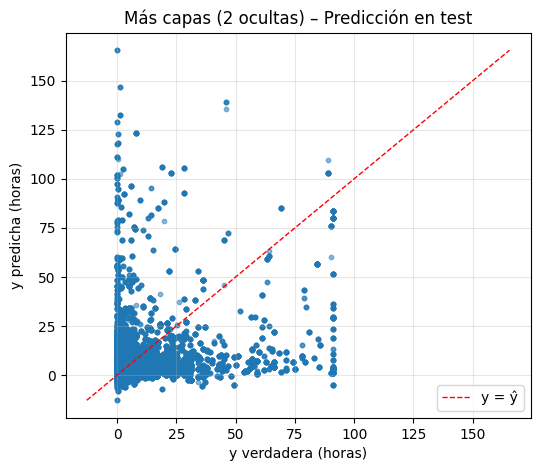


== Comparativo (menor MAE es mejor) ==


,Modelo,Test_MSE,Test_MAE,Test_R2
0,Más capas (2 ocultas),280.666700,8.720206,-0.395950
1,No lineal (1 oculta),264.043035,9.558807,-0.313269


In [4]:
# Importar Librerias
import os, json, math, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ---------- Configuración ----------
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

# ----------  Objetivo (y) ----------
TARGET = "resolution_time"   

# Alineamos y filtramos filas válidas (y ≥ 0 y no NaN)
d = df.copy()
mask_valid = d[TARGET].notna() & (d[TARGET] >= 0)
d = d.loc[mask_valid].copy()
X = X.loc[mask_valid].copy()

# Cap de etiqueta al p99 para estabilidad (entrenamiento más robusto)
p99 = d[TARGET].quantile(0.99)
d[TARGET] = np.minimum(d[TARGET], p99)

y_all = d[TARGET].astype(float).values.reshape(-1, 1)

# ---------- Split temporal 80/20 (mismo para todos los modelos) ----------
dt_open = pd.to_datetime(d["opened_at"], errors="coerce")
cutoff = dt_open.quantile(0.80)
is_train = (dt_open <= cutoff).fillna(True).values
is_test  = (dt_open >  cutoff).fillna(False).values

X_train_raw, X_test_raw = X.iloc[is_train], X.iloc[is_test]
y_train, y_test = y_all[is_train], y_all[is_test]

print(f"Cutoff temporal: {cutoff}")
print("Train:", X_train_raw.shape, " Test:", X_test_raw.shape)

# ----------  Preprocesamiento: numéricas vs categóricas ----------
num_features = [c for c in ["opened_month","opened_time_decimal","opened_is_weekend"] if c in X.columns]
cat_features = [c for c in ["opened_dow_name","impact","urgency","contact_type","category","subcategory","location"] if c in X.columns]

num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", RobustScaler())
])

# compatibilidad sklearn>=1.4 y previas
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", ohe)
])

pre = ColumnTransformer([
    ("num", num_pipe, num_features),
    ("cat", cat_pipe, cat_features)
])

# Fit solo con TRAIN y transformar
X_train = pre.fit_transform(X_train_raw)
X_test  = pre.transform(X_test_raw)

in_dim = X_train.shape[1]
print("Dimensión de entrada tras OHE+escala:", in_dim)

# ---------- Tensores y DataLoader ----------
Xtr_t = torch.tensor(X_train, dtype=torch.float32).to(DEVICE)
ytr_t = torch.tensor(y_train, dtype=torch.float32).to(DEVICE)
Xte_t = torch.tensor(X_test,  dtype=torch.float32).to(DEVICE)
yte_t = torch.tensor(y_test,  dtype=torch.float32).to(DEVICE)

train_ds = TensorDataset(Xtr_t, ytr_t)
train_dl = DataLoader(train_ds, batch_size=1024, shuffle=True)

# ---------- Utilidades de entrenamiento/plot ----------
def train_model(model, train_loader, epochs=60, lr=5e-3, loss_fn=None):
    """
    Entrena el modelo en MSE y retorna el historial de pérdida (train).
    """
    model = model.to(DEVICE)
    if loss_fn is None:
        loss_fn = nn.MSELoss()
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    hist = []

    for ep in range(1, epochs+1):
        model.train()
        ep_loss = 0.0
        n = 0
        for xb, yb in train_loader:
            opt.zero_grad()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            opt.step()
            bs = xb.size(0)
            ep_loss += loss.item() * bs
            n += bs
        ep_loss /= max(1, n)
        hist.append(ep_loss)
        if ep % max(1, epochs//6) == 0:
            print(f"Epoch {ep:3d}/{epochs}  train MSE={ep_loss:.4f}")
    return hist

def evaluate_model(model, X_test_t, y_test_np, title="Modelo"):
    model.eval()
    with torch.no_grad():
        yhat = model(X_test_t).cpu().numpy().reshape(-1)
    y_true = y_test_np.reshape(-1)

    mse = mean_squared_error(y_true, yhat)
    mae = mean_absolute_error(y_true, yhat)
    r2  = r2_score(y_true, yhat)
    print(f"[{title}] Test  MSE={mse:.4f}  MAE={mae:.4f}  R2={r2:.4f}")

    # Dispersión y_pred vs y_true
    plt.figure(figsize=(6,5))
    plt.scatter(y_true, yhat, s=10, alpha=0.5)
    lims = [min(y_true.min(), yhat.min()), max(y_true.max(), yhat.max())]
    plt.plot(lims, lims, 'r--', lw=1, label='y = ŷ')
    plt.xlabel("y verdadera (horas)")
    plt.ylabel("y predicha (horas)")
    plt.title(f"{title} – Predicción en test")
    plt.legend(); plt.grid(alpha=0.3)
    plt.show()

    return mse, mae, r2

def plot_history(hist, title="Historial de pérdida (MSE)"):
    plt.figure(figsize=(6,4))
    plt.plot(hist, lw=2)
    plt.xlabel("Epoch"); plt.ylabel("Train MSE")
    plt.title(title); plt.grid(alpha=0.3)
    plt.show()

# ---------- MODELO NO LINEAL (MLP con 1 capa oculta + ReLU) ----------
class MLP1(nn.Module):
    def __init__(self, in_features, hidden=128, dropout=0.0):
        super().__init__()
        layers = [
            nn.Linear(in_features, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, 1)
        ]
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

model_nl = MLP1(in_dim, hidden=128, dropout=0.10)
hist_nl = train_model(model_nl, train_dl, epochs=60, lr=5e-3)  # ajusta epochs si necesitas
plot_history(hist_nl, "Modelo No Lineal (1 oculta) – Historial de entrenamiento")
mse_nl, mae_nl, r2_nl = evaluate_model(model_nl, Xte_t, y_test, title="No lineal (1 oculta)")

# ---------- MODELO “MÁS CAPAS” (2 ocultas + ReLU) ----------
class MLP2(nn.Module):
    def __init__(self, in_features, h1=256, h2=128, dropout=0.1):
        super().__init__()
        layers = [
            nn.Linear(in_features, h1),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(h1, h2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(h2, 1)
        ]
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

model_deep = MLP2(in_dim, h1=256, h2=128, dropout=0.10)
hist_dp = train_model(model_deep, train_dl, epochs=80, lr=3e-3)
plot_history(hist_dp, "Modelo Más Capas (2 ocultas) – Historial de entrenamiento")
mse_dp, mae_dp, r2_dp = evaluate_model(model_deep, Xte_t, y_test, title="Más capas (2 ocultas)")

# ---------- 9) COMPARATIVO FINAL ----------
resumen = pd.DataFrame([
    {"Modelo":"No lineal (1 oculta)", "Test_MSE":mse_nl, "Test_MAE":mae_nl, "Test_R2":r2_nl},
    {"Modelo":"Más capas (2 ocultas)", "Test_MSE":mse_dp, "Test_MAE":mae_dp, "Test_R2":r2_dp},
]).sort_values("Test_MAE").reset_index(drop=True)

print("\n== Comparativo (menor MAE es mejor) ==")
display(resumen)


### Evaluación e Implementación Modelo sin Variables de tiempo

Device: cpu
Cutoff temporal: 2016-05-08 19:01:00
Train: (95161, 6)  Test: (23784, 6)
Dimensión de entrada tras OneHot: 457
Epoch  10/60  train MSE=168.7810
Epoch  20/60  train MSE=160.9167
Epoch  30/60  train MSE=155.4687
Epoch  40/60  train MSE=150.2708
Epoch  50/60  train MSE=145.5384
Epoch  60/60  train MSE=141.9244


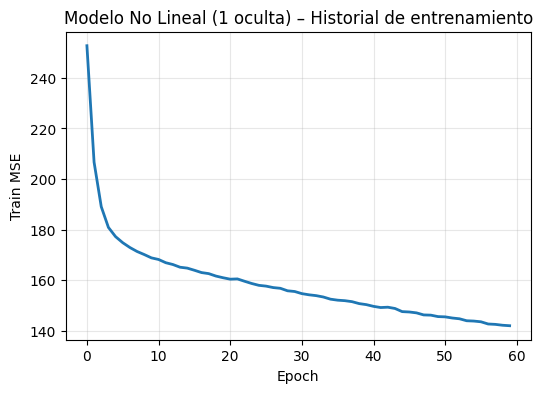

[No lineal (1 oculta)] Test  MSE=206.4692  MAE=8.7417  R2=-0.0269


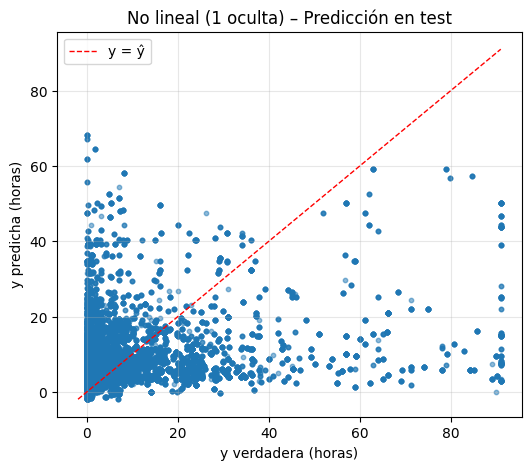

Epoch  13/80  train MSE=131.4805
Epoch  26/80  train MSE=123.7626
Epoch  39/80  train MSE=121.5846
Epoch  52/80  train MSE=121.2840
Epoch  65/80  train MSE=120.5988
Epoch  78/80  train MSE=120.2610


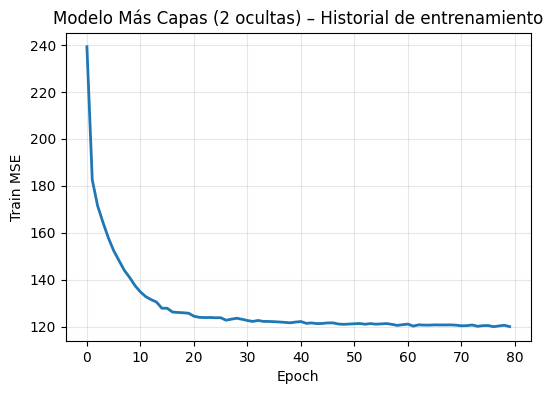

[Más capas (2 ocultas)] Test  MSE=214.5837  MAE=8.7208  R2=-0.0673


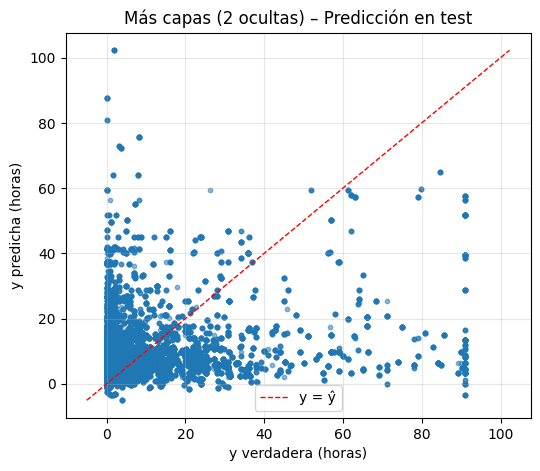


== Comparativo (menor MAE es mejor) ==


,Modelo,Test_MSE,Test_MAE,Test_R2
0,Más capas (2 ocultas),214.583749,8.720818,-0.067274
1,No lineal (1 oculta),206.469237,8.741674,-0.026914


In [5]:
# ==============================================
#  PyTorch: Regresión MULTIVARIABLE sin tiempo
#  X = [impact, urgency, contact_type, category, subcategory, location]
#  Modelos: MLP 1 oculta  y  MLP 2 ocultas
# ==============================================
# %pip install torch scikit-learn matplotlib -q  # descomenta si te faltan paquetes

import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ---------- Config ----------
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

# ---------- 1) Cargar df (usa el que ya tengas; si no, intento ruta conocida) ----------
if "df" not in globals():
    csv_candidates = [
        "incident_event_log_clean.csv",
        "/Users/anasofiaarizmendi/Desktop/U/20252/Analitica/Proyecto 1/Repo_Proyecto_1/Tarea_3/incident_event_log_clean.csv",
    ]
    csv_path = next((p for p in csv_candidates if os.path.exists(p)), None)
    if csv_path is None:
        raise FileNotFoundError("No se encontró el CSV. Ajusta 'csv_candidates'.")
    df = pd.read_csv(csv_path)
    print("Usando CSV:", csv_path)

# ---------- 2) Etiqueta: resolution_time (constrúyela si faltara) ----------
def to_dt(s):
    return pd.to_datetime(s, errors="coerce", utc=True).dt.tz_localize(None)

if "resolution_time" not in df.columns:
    dt_o = to_dt(df.get("opened_at"))
    dt_r = to_dt(df.get("resolved_at"))
    df["resolution_time"] = (dt_r - dt_o).dt.total_seconds()/3600.0

# Filtra filas válidas y cap p99 para estabilidad
d = df.copy()
mask = d["resolution_time"].notna() & (d["resolution_time"] >= 0)
d = d.loc[mask].copy()
cap = d["resolution_time"].quantile(0.99)
d["resolution_time"] = np.minimum(d["resolution_time"], cap)

# ---------- 3) Features SOLO categóricas pedidas ----------
CAT_FEATS = ["impact","urgency","contact_type","category","subcategory","location"]
missing = [c for c in CAT_FEATS if c not in d.columns]
if missing:
    raise KeyError(f"Faltan columnas en el DataFrame: {missing}")

X_raw = d[CAT_FEATS].copy()
y_all = d["resolution_time"].astype(float).values.reshape(-1,1)

# ---------- 4) Split temporal 80/20 (opened_at solo para partir, NO se usa como X) ----------
dt_open = pd.to_datetime(d["opened_at"], errors="coerce")
cutoff = dt_open.quantile(0.80)
is_train = (dt_open <= cutoff).fillna(True).values
is_test  = (dt_open >  cutoff).fillna(False).values

X_train_raw, X_test_raw = X_raw.iloc[is_train], X_raw.iloc[is_test]
y_train, y_test = y_all[is_train], y_all[is_test]

print(f"Cutoff temporal: {cutoff}")
print("Train:", X_train_raw.shape, " Test:", X_test_raw.shape)

# ---------- 5) Preprocesamiento: OneHot para TODAS las categóricas ----------
# Imputamos con la moda y luego OHE. Sin límite de cardinalidad.
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

pre = ColumnTransformer([
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", ohe)
    ]), CAT_FEATS)
])

X_train = pre.fit_transform(X_train_raw)
X_test  = pre.transform(X_test_raw)
in_dim = X_train.shape[1]
print("Dimensión de entrada tras OneHot:", in_dim)

# ---------- 6) Tensores/Dataloader ----------
Xtr_t = torch.tensor(X_train, dtype=torch.float32).to(DEVICE)
ytr_t = torch.tensor(y_train, dtype=torch.float32).to(DEVICE)
Xte_t = torch.tensor(X_test,  dtype=torch.float32).to(DEVICE)
yte_t = torch.tensor(y_test,  dtype=torch.float32).to(DEVICE)

train_ds = TensorDataset(Xtr_t, ytr_t)
train_dl = DataLoader(train_ds, batch_size=2048, shuffle=True)

# ---------- 7) Utilidades de entrenamiento, evaluación y plots ----------
def train_model(model, train_loader, epochs=60, lr=5e-3):
    """Entrena con MSE y devuelve historial de pérdida (train)."""
    model = model.to(DEVICE)
    loss_fn = nn.MSELoss()
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    hist = []
    for ep in range(1, epochs+1):
        model.train(); ep_loss = 0.0; n=0
        for xb, yb in train_loader:
            opt.zero_grad()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward(); opt.step()
            bs = xb.size(0); ep_loss += loss.item()*bs; n += bs
        hist.append(ep_loss/max(1,n))
        if ep % max(1, epochs//6)==0:
            print(f"Epoch {ep:3d}/{epochs}  train MSE={hist[-1]:.4f}")
    return hist

def evaluate_model(model, X_test_t, y_test_np, title="Modelo"):
    model.eval()
    with torch.no_grad():
        yhat = model(X_test_t).cpu().numpy().reshape(-1)
    y_true = y_test_np.reshape(-1)
    mse = mean_squared_error(y_true, yhat)
    mae = mean_absolute_error(y_true, yhat)
    r2  = r2_score(y_true, yhat)
    print(f"[{title}] Test  MSE={mse:.4f}  MAE={mae:.4f}  R2={r2:.4f}")

    # Dispersión ŷ vs y
    plt.figure(figsize=(6,5))
    plt.scatter(y_true, yhat, s=10, alpha=0.5)
    lims = [min(y_true.min(), yhat.min()), max(y_true.max(), yhat.max())]
    plt.plot(lims, lims, 'r--', lw=1, label='y = ŷ')
    plt.xlabel("y verdadera (horas)"); plt.ylabel("y predicha (horas)")
    plt.title(f"{title} – Predicción en test")
    plt.legend(); plt.grid(alpha=0.3); plt.show()

    return mse, mae, r2

def plot_history(hist, title="Historial de pérdida (MSE)"):
    plt.figure(figsize=(6,4))
    plt.plot(hist, lw=2)
    plt.xlabel("Epoch"); plt.ylabel("Train MSE")
    plt.title(title); plt.grid(alpha=0.3); plt.show()

# ---------- 8) Modelo NO LINEAL (1 capa oculta + ReLU) ----------
class MLP1(nn.Module):
    def __init__(self, in_features, hidden=128, dropout=0.10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, 1)
        )
    def forward(self, x):
        return self.net(x)

model_nl = MLP1(in_dim, hidden=128, dropout=0.10)
hist_nl = train_model(model_nl, train_dl, epochs=60, lr=5e-3)
plot_history(hist_nl, "Modelo No Lineal (1 oculta) – Historial de entrenamiento")
mse_nl, mae_nl, r2_nl = evaluate_model(model_nl, Xte_t, y_test, "No lineal (1 oculta)")

# ---------- 9) Modelo MÁS CAPAS (2 ocultas + ReLU) ----------
class MLP2(nn.Module):
    def __init__(self, in_features, h1=256, h2=128, dropout=0.10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features, h1),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(h1, h2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(h2, 1)
        )
    def forward(self, x):
        return self.net(x)

model_dp = MLP2(in_dim, h1=256, h2=128, dropout=0.10)
hist_dp = train_model(model_dp, train_dl, epochs=80, lr=3e-3)
plot_history(hist_dp, "Modelo Más Capas (2 ocultas) – Historial de entrenamiento")
mse_dp, mae_dp, r2_dp = evaluate_model(model_dp, Xte_t, y_test, "Más capas (2 ocultas)")

# ---------- 10) Comparativo ----------
resumen = pd.DataFrame([
    {"Modelo":"No lineal (1 oculta)",  "Test_MSE":mse_nl, "Test_MAE":mae_nl, "Test_R2":r2_nl},
    {"Modelo":"Más capas (2 ocultas)", "Test_MSE":mse_dp, "Test_MAE":mae_dp, "Test_R2":r2_dp},
]).sort_values("Test_MAE").reset_index(drop=True)

print("\n== Comparativo (menor MAE es mejor) ==")
display(resumen)

# ---------- (Opcional) Guardado para dashboard ----------
# torch.save(model_nl.state_dict(), "model_nolineal.pt")
# torch.save(model_dp.state_dict(), "model_mascapas.pt")
# import joblib; joblib.dump(pre, "pre_onehot.joblib")


### Tercer Modelo - Modelo final

Cutoff temporal: 2016-05-08 19:01:00
Train: (95161, 8)  Test: (23784, 8)
Dimensión de entrada: 21


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (95161, 21)            │            43 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43 (176.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 43 (176.00 B)

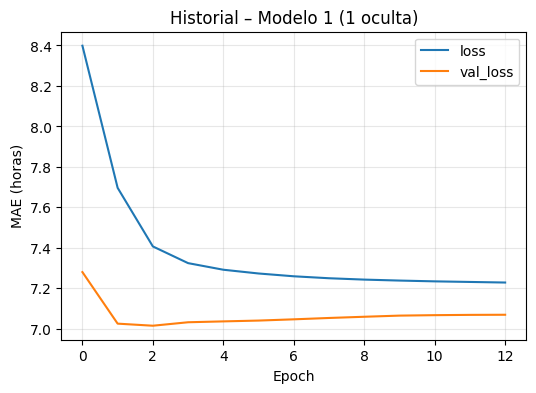

[Modelo 1] Test  MAE=6.742  MSE=182.176  R2=0.0939


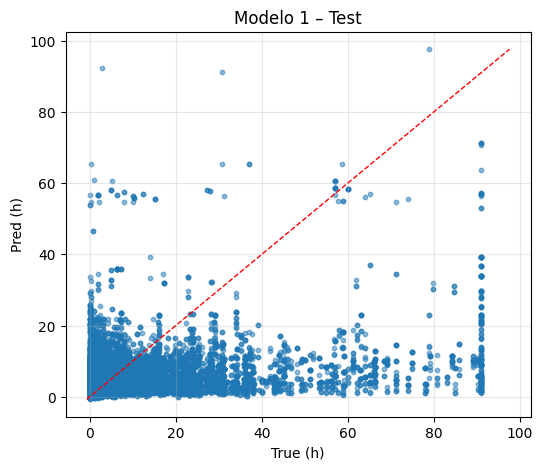

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 21)             │            43 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43 (176.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 43 (176.00 B)

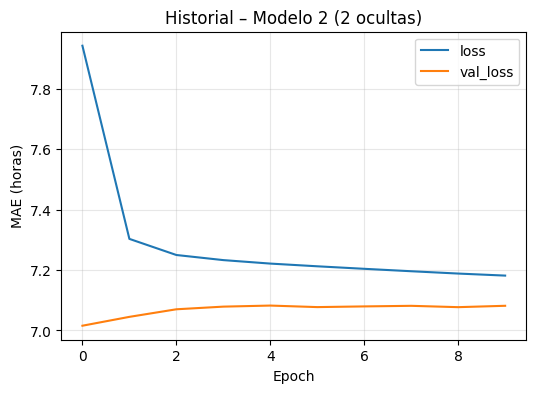

[Modelo 2] Test  MAE=6.892  MSE=184.061  R2=0.0845


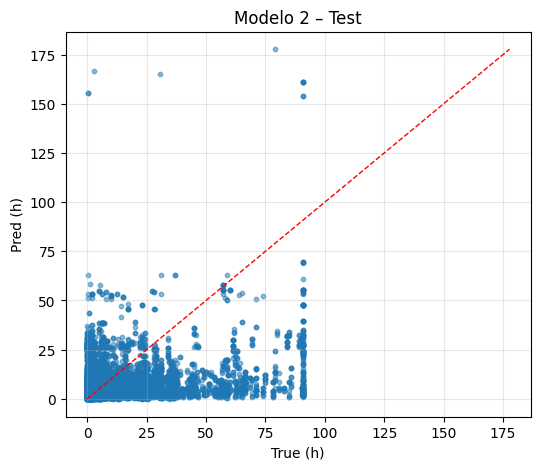


== Comparativo (menor MAE mejor) ==


,Modelo,Test_MAE,Test_MSE,Test_R2
0,DNN(1 oculta),6.741933,182.175705,0.093914
1,DNN(2 ocultas),6.891922,184.060516,0.084540


In [6]:
# ==========================================================
#   Modelo solo con:
#  impact, urgency, contact_type, category, subcategory,
#  location, notify, incident_state
#  OHE (baja card.) + Target Encoding (alta card.)
# ==========================================================
# %pip install tensorflow scikit-learn matplotlib -q

import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf

# ---------- Config reproducible ----------
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# ---------- Carga df ----------
if "df" not in globals():
    csv_candidates = [
        "incident_event_log_clean.csv",
        "/Users/anasofiaarizmendi/Desktop/U/20252/Analitica/Proyecto 1/Repo_Proyecto_1/Tarea_3/incident_event_log_clean.csv",
    ]
    csv_path = next((p for p in csv_candidates if os.path.exists(p)), None)
    if csv_path is None:
        raise FileNotFoundError("Ajusta la ruta del CSV limpio.")
    df = pd.read_csv(csv_path)
    print("Usando CSV:", csv_path)

# ---------- Etiqueta: resolution_time ----------
def to_dt(s): 
    return pd.to_datetime(s, errors="coerce", utc=True).dt.tz_localize(None)

if "resolution_time" not in df.columns:
    df["resolution_time"] = (to_dt(df.get("resolved_at")) - to_dt(df.get("opened_at"))).dt.total_seconds()/3600.0

d = df.copy()
mask = d["resolution_time"].notna() & (d["resolution_time"] >= 0)
d = d.loc[mask].copy()

# cap p99 para estabilizar entrenamiento (reduce impacto de colas largas)
p99 = d["resolution_time"].quantile(0.99)
d["resolution_time"] = np.minimum(d["resolution_time"], p99)

# ---------- Features solicitadas ----------
LOW_CAT  = ["impact","urgency","contact_type","notify","incident_state"]  # OHE
HIGH_CAT = ["category","subcategory","location"]                          # Target Encoding

for c in LOW_CAT + HIGH_CAT:
    if c not in d.columns:
        d[c] = np.nan   # por si faltara alguna

X_raw = d[LOW_CAT + HIGH_CAT].copy()
y_all = d["resolution_time"].astype(float).values.reshape(-1, 1)

# ---------- Split temporal 80/20 (opened_at SOLO para partir) ----------
dt_open = pd.to_datetime(d["opened_at"], errors="coerce")
cutoff  = dt_open.quantile(0.80)
is_train = (dt_open <= cutoff).fillna(True).values
is_test  = (dt_open >  cutoff).fillna(False).values

X_train_raw, X_test_raw = X_raw.iloc[is_train], X_raw.iloc[is_test]
y_train, y_test = y_all[is_train], y_all[is_test]
print(f"Cutoff temporal: {cutoff}\nTrain: {X_train_raw.shape}  Test: {X_test_raw.shape}")

# ---------- Target Encoding (m-estimate) para alta cardinalidad ----------
def fit_te(x: pd.Series, y: np.ndarray, m: float = 80.0):
    """
    Suavizado m-estimate:
    enc(v) = (n_v*mean_v + m*global_mean) / (n_v + m)
    """
    dfte = pd.DataFrame({"x": x.astype("object").values, "y": y.reshape(-1)})
    g = dfte["y"].mean()
    gby = dfte.groupby("x")["y"].agg(["mean","count"])
    enc = (gby["count"]*gby["mean"] + m*g) / (gby["count"] + m)
    return enc.to_dict(), float(g)

def apply_te(x: pd.Series, mapping: dict, g: float):
    return x.astype("object").map(mapping).fillna(g).astype(float).values.reshape(-1,1)

te_maps = {}
Xtr_te_parts, Xte_te_parts = [], []
for col in HIGH_CAT:
    te_maps[col] = fit_te(X_train_raw[col], y_train, m=80.0)
    Xtr_te_parts.append(apply_te(X_train_raw[col], *te_maps[col]))
    Xte_te_parts.append(apply_te(X_test_raw[col],  *te_maps[col]))

# ---------- One-Hot para baja cardinalidad ----------
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

ohe_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", ohe)
])
Xtr_ohe = ohe_pipe.fit_transform(X_train_raw[LOW_CAT])
Xte_ohe = ohe_pipe.transform(X_test_raw[LOW_CAT])

# ---------- Ensamble final de matrices ----------
train_X = np.hstack(Xtr_te_parts + [Xtr_ohe]).astype("float32")
test_X  = np.hstack(Xte_te_parts + [Xte_ohe]).astype("float32")
train_y = y_train.astype("float32")
test_y  = y_test.astype("float32")

print("Dimensión de entrada:", train_X.shape[1])

# ---------- Normalization layer (como en la actividad) ----------
norm = tf.keras.layers.Normalization()
norm.adapt(train_X)

# =======================
#  MODELO 1 (1 oculta)
# =======================
model1 = tf.keras.Sequential([
    norm,
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])
model1.summary()
model1.compile(
    loss='mean_absolute_error',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3)
)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

hist1 = model1.fit(
    train_X, train_y,
    validation_split=0.2,
    epochs=100,
    batch_size=1024,
    callbacks=[es],
    verbose=0
)

plt.figure(figsize=(6,4))
plt.plot(hist1.history['loss'], label='loss')
plt.plot(hist1.history['val_loss'], label='val_loss')
plt.xlabel('Epoch'); plt.ylabel('MAE (horas)')
plt.title('Historial – Modelo 1 (1 oculta)')
plt.legend(); plt.grid(alpha=0.3); plt.show()

mae1 = model1.evaluate(test_X, test_y, verbose=0)
pred1 = model1.predict(test_X, verbose=0).flatten()
mse1  = mean_squared_error(test_y, pred1)
r2_1  = r2_score(test_y, pred1)
print(f"[Modelo 1] Test  MAE={mae1:.3f}  MSE={mse1:.3f}  R2={r2_1:.4f}")

plt.figure(figsize=(6,5))
plt.scatter(test_y, pred1, s=10, alpha=0.5)
lims = [min(test_y.min(), pred1.min()), max(test_y.max(), pred1.max())]
plt.plot(lims, lims, 'r--', lw=1)
plt.xlabel('True (h)'); plt.ylabel('Pred (h)')
plt.title('Modelo 1 – Test'); plt.grid(alpha=0.3); plt.show()

# =======================
#  MODELO 2 (2 ocultas)
# =======================
model2 = tf.keras.Sequential([
    norm,
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64,  activation='relu'),
    tf.keras.layers.Dense(1)
])
model2.summary()
model2.compile(
    loss='mean_absolute_error',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3)
)

hist2 = model2.fit(
    train_X, train_y,
    validation_split=0.2,
    epochs=120,
    batch_size=1024,
    callbacks=[es],
    verbose=0
)

plt.figure(figsize=(6,4))
plt.plot(hist2.history['loss'], label='loss')
plt.plot(hist2.history['val_loss'], label='val_loss')
plt.xlabel('Epoch'); plt.ylabel('MAE (horas)')
plt.title('Historial – Modelo 2 (2 ocultas)')
plt.legend(); plt.grid(alpha=0.3); plt.show()

mae2 = model2.evaluate(test_X, test_y, verbose=0)
pred2 = model2.predict(test_X, verbose=0).flatten()
mse2  = mean_squared_error(test_y, pred2)
r2_2  = r2_score(test_y, pred2)
print(f"[Modelo 2] Test  MAE={mae2:.3f}  MSE={mse2:.3f}  R2={r2_2:.4f}")

plt.figure(figsize=(6,5))
plt.scatter(test_y, pred2, s=10, alpha=0.5)
lims = [min(test_y.min(), pred2.min()), max(test_y.max(), pred2.max())]
plt.plot(lims, lims, 'r--', lw=1)
plt.xlabel('True (h)'); plt.ylabel('Pred (h)')
plt.title('Modelo 2 – Test'); plt.grid(alpha=0.3); plt.show()

# ---------- Comparativo ----------
res_df = pd.DataFrame([
    {"Modelo":"DNN(1 oculta)","Test_MAE":float(mae1),"Test_MSE":float(mse1),"Test_R2":float(r2_1)},
    {"Modelo":"DNN(2 ocultas)","Test_MAE":float(mae2),"Test_MSE":float(mse2),"Test_R2":float(r2_2)},
]).sort_values("Test_MAE").reset_index(drop=True)

print("\n== Comparativo (menor MAE mejor) ==")
display(res_df)


Se selecciona el modelo 1 con 1 capa

In [7]:
# === Guardar artefactos para el tablero ===
import json, os
ART_DIR = "Tarea_4/artifacts"
os.makedirs(ART_DIR, exist_ok=True)

# predicciones de test (ambos modelos)
preds_df = pd.DataFrame({
    "y_true":  test_y.reshape(-1),
    "y_pred":  pred1,
    "model":   "DNN_1_hidden"
})
preds_df2 = pd.DataFrame({
    "y_true":  test_y.reshape(-1),
    "y_pred":  pred2,
    "model":   "DNN_2_hidden"
})
preds_all = pd.concat([preds_df, preds_df2], ignore_index=True)
preds_all.to_csv(os.path.join(ART_DIR, "predictions_test.csv"), index=False)

# métricas
metrics = [
    {"model": "DNN_1_hidden", "MAE": float(mae1), "MSE": float(mse1), "R2": float(r2_1)},
    {"model": "DNN_2_hidden", "MAE": float(mae2), "MSE": float(mse2), "R2": float(r2_2)},
]
with open(os.path.join(ART_DIR, "metrics.json"), "w") as f:
    json.dump(metrics, f, indent=2)
print(f"[OK] Artefactos guardados en {ART_DIR}")

[OK] Artefactos guardados en Tarea_4/artifacts
